In [1]:
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from pathlib import Path
from typing import NamedTuple

In [2]:
class LogEntry(NamedTuple):
    mibps: float
    tps: int

In [3]:
#TODO: Check units
def parse_logs(path):
    with path.open() as f:
        for line in f:
            match = re.search(r"\[MON\] S000 (?P<mbps>\d+\.\d*) MB/s \((?P<tps>\d+) tuples/sec\)", line)
            if match:
                yield LogEntry(mbps=float(match["mbps"]), tps=int(match["tps"]))
            
    
    

In [4]:
def read_experiment(path: Path) -> pd.DataFrame:
    with (path/"metadata.json").open() as f:
        metadata = json.load(f)
    entries = list(parse_logs(path / "gw_consumer.log"))[:-1]
    df = pd.DataFrame.from_records(entries, columns=["mibps", "tps"])
    df["tps"] = df["tps"].astype(float)
    df["batch_size"] = int(metadata["batch_size"])
    df["interleaved"] = bool(metadata["interleaved"])
    return df

In [5]:
def read_logs(path: Path):
    dfs = []
    for path in path.iterdir():
        assert path.is_dir()
        dfs.append(read_experiment(path))
    return pd.concat(dfs)
        

In [9]:
data = read_logs(Path("/home/hendrik/projects/ghostwriter/ghostwriter/benchmarking/data/ysb/2023-03-10/114213"))

In [12]:
data

,mbps,tps,batch_size,interleaved


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [37]:
isolated = read_logs(Path("/home/hendrik/projects/ghostwriter/ghostwriter/benchmarking/data/ysb/2023-02-17/085252"))

In [38]:
isolated["tps"].unique

<bound method Series.unique of 0     2321408.0
1     2287616.0
2     2313216.0
3     2304000.0
4     2287616.0
        ...    
2    75872256.0
3    76228608.0
4    76066816.0
5    76424192.0
6    76100608.0
Name: tps, Length: 681, dtype: float64>

In [39]:
isolated.groupby(["batch_size", "interleaved"])["mbps"].mean()

batch_size  interleaved
2048        False           280.078741
4096        False           493.304116
8192        False           900.260878
16384       False          1574.677451
32768       False          2559.047065
65536       False          4117.412389
131072      False          5965.129167
262144      False          7462.225400
524288      False          8625.464625
1048576     False          9299.678571
Name: mbps, dtype: float64

In [70]:
producer_kd = pd.DataFrame.from_records(
    [
        (2048, 87.44),
        (4096, 169.22),
        (8192, 337.34),
        (16384, 714.84),
        (32768, 1079.06),
        (65536, 2130),
        (131072, 3183.75),
        (262144, 4272.5),
        (524288, 5840),
    ]
)

In [69]:
consumer_kd = pd.DataFrame.from_records(
    [
        (2048, 19.6689), 
        (4096, 40.3122), 
        (8192, 78.3601), 
        (16384, 144.4085), 
        (32768, 247.0356), 
        (65536, 431.9281),
        (131072, 681.5703),
        (262144, 920.8103),
        (524288, 927.9881),
    ],
    columns=["batch_size", "mbps"]
)

In [51]:
isolated.dtypes

mbps           float64
tps            float64
batch_size       int64
interleaved       bool
dtype: object

In [41]:
kafka_direct

,batch_size,mbps
0,2048,19.6689
1,4096,40.3122
2,8192,78.3601
3,16384,144.4085
4,32768,247.0356
5,65536,431.9281
6,131072,681.5703
7,262144,920.8103
8,524288,927.9881


In [52]:
isolated[["batch_size", "mbps"]].

batch_size      int64
mbps          float64
dtype: object

In [65]:
df_gw = isolated[["batch_size", "mbps"]]
df_gw = df_gw.assign(broker='Ghostwriter')
df_kd = kafka_direct
df_kd = df_kd.assign(broker="KafkaDirect")
df = pd.concat([df_gw, df_kd])

In [58]:
import seaborn as sns

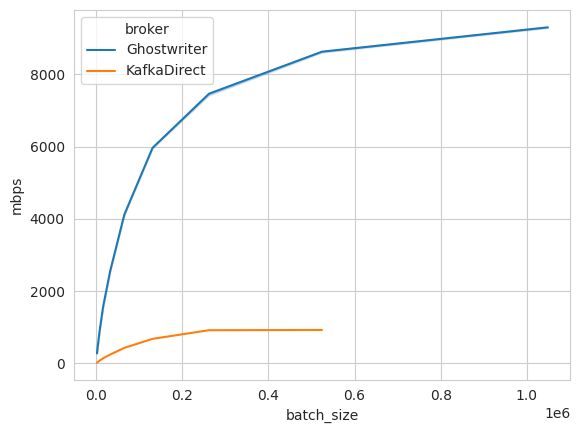

In [67]:
plot = sns.lineplot(df, x="batch_size", y="mbps", hue="broker")

In [68]:
plot.figure.savefig("ysb_isolated_consumers.png")


In [59]:
sns.set_style("whitegrid")

In [71]:
interleaved = read_logs(Path("/home/hendrik/projects/ghostwriter/ghostwriter/benchmarking/data/ysb/2023-02-17/095724"))

In [72]:
interleaved

,mbps,tps,batch_size,interleaved
0,378.247,3101696.0,16384,True
1,386.875,3169280.0,16384,True
2,413.875,3390464.0,16384,True
3,703.250,5761024.0,16384,True
4,703.750,5765120.0,16384,True
...,...,...,...,...
361,0.125,1024.0,1024,True
362,0.000,0.0,1024,True
363,0.000,0.0,1024,True
364,0.000,0.0,1024,True


In [ ]:
df_gw = [["batch_size", "mbps"]]
df_gw = df_gw.assign(broker='Ghostwriter')
df_kd = kafka_direct
df_kd = df_kd.assign(broker="KafkaDirect")
df = pd.concat([df_gw, df_kd])

## Isolated YSB Throughput

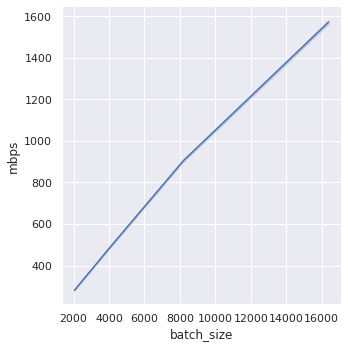

In [70]:
sns.relplot(
    data=isolated[isolated["batch_size"] <= 32000], kind="line",
    x="batch_size", y="mbps", errorbar="sd"
)

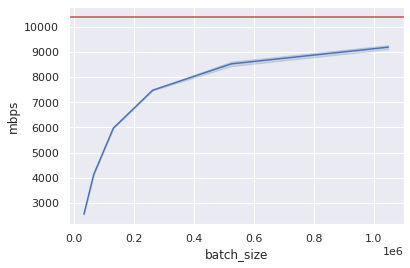

In [85]:
graph = sns.lineplot(
    data=isolated[isolated["batch_size"] >= 32000], #kind="line",
    x="batch_size", y="mbps", errorbar="sd"
)
graph.axhline(y = 10400, color = 'r', linestyle = '-')

## Interleaved YSB Throughput

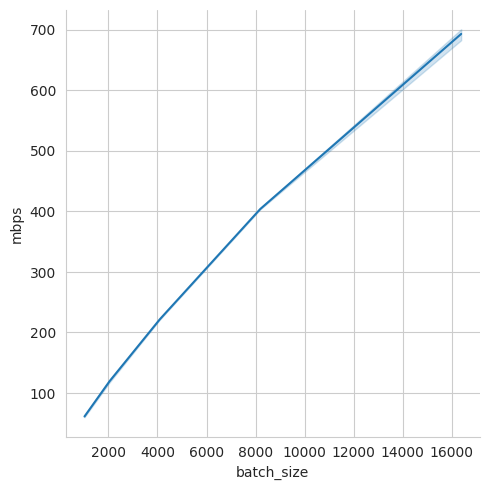

In [75]:
sns.relplot(
    data=interleaved[interleaved["batch_size"] <= 32000], kind="line",
    x="batch_size", y="mbps"
)

In [88]:
df = interleaved.groupby(["batch_size"])[["mbps"]].mean()

In [89]:
df

,mbps
batch_size,
1024,61.032568
2048,119.371244
4096,221.621622
8192,403.889441
16384,693.190863
32768,1200.303529
65536,2023.660150
131072,3120.642385
262144,4228.824421


In [83]:
5242880000 / 1024 / 1024

5000.0

In [96]:
df["batch_size"]

KeyError: 'batch_size'

In [84]:
df[1048576] = 5242880000 / 1024 / 1024
df[524288] = 5158993920 / 1024 / 1024
df[262144] = 4445962240/ 1024 / 1024
df[131072] = 3313500160/ 1024 / 1024

<Axes: xlabel='batch_size'>

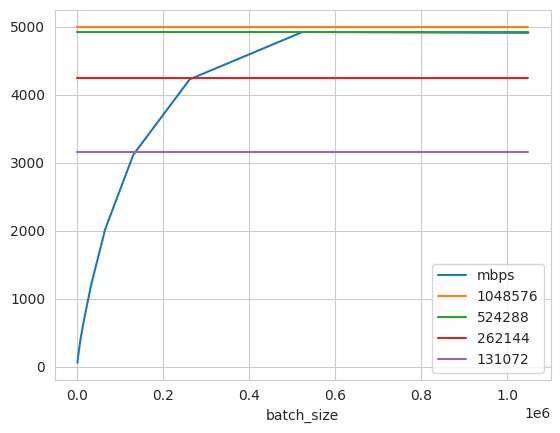

In [87]:
df.plot()

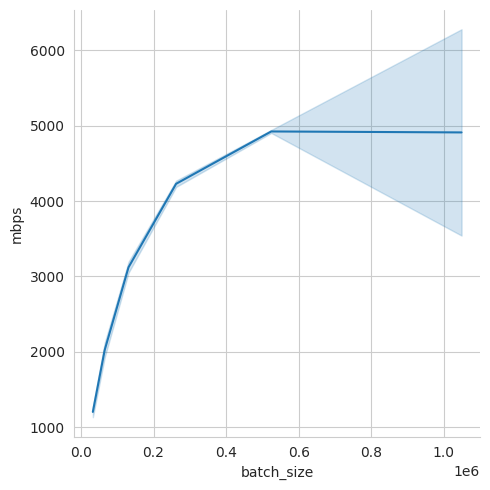

In [73]:
sns.relplot(
    data=interleaved[interleaved["batch_size"] >= 32000], kind="line",
    x="batch_size", y="mbps", errorbar="sd"
)

--> need to identify sustainable throughput (producer produced faster than consumer)